In [14]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
import importlib


from ATARI.sammy_interface import sammy_interface, sammy_classes, sammy_functions, template_creator

from ATARI.ModelData.particle_pair import Particle_Pair

from ATARI.ModelData.experimental_model import Experimental_Model

from copy import copy


In [15]:
%matplotlib widget

## Measurement Data

The following measurement data are imported from the work of Jesse Brown at RPI (currently at ORNL).
These measurements are detailed in https://www.tandfonline.com/doi/full/10.1080/00295639.2023.2249786 and consist of 6 experimental configurations.
Of the 4 transmission measurements only 3 are used for evaluation and the 4th (45m FP) is used for validation. 
Both 2 capture measurements are used in evaluation.

The transmission data are reliable in the range 0.15-100 keV.
The capture data are reliable from 0.15-200 keV. 



In [174]:
### Determine channel widths
from ATARI.theory.experimental import e_to_t, t_to_e

def get_chw_and_upperE(E, FP):
    E = np.array(E)
    tof = e_to_t(E, FP, True)
    dt = np.diff(tof*1e6)
    widths1, index1 = np.unique(np.round(dt, 4), return_index=True)
    chw, Emax = np.flipud(widths1), np.flipud(E[index1])
    strc = ''
    stre = ''
    for c,e in zip(chw, Emax):
        strc += f"{c*1e3:.2f}, "
        stre += f"{e:.2f}, "
    return stre, strc

# Emax, chw = get_chw_and_upperE(transdat6.E, 100.14)
# Emax, chw = get_chw_and_upperE(capdat1.E, 45.27)
# print(Emax)
# print(chw)
# energy_range_all = [150, 6000]
# energy_range_all = [201, 228]
# energy_range_all = [201, 210]
energy_range_all = [190, 260]

In [175]:
# 147/ 
(147.882/216)

0.6846388888888889

In [176]:
### 1mm capture data
capdat1 = sammy_functions.readlst("./yield_ta1b_unsmooth.dat")
expcap1 = Experimental_Model(title = "cap1mm",
                                reaction ="capture", 
                                energy_range = energy_range_all,
                                n = (0.005631, 0),
                                FP = (45.27, 0.05),
                                burst= (8.0,1.0), 
                                temp= (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat1 = capdat1[(capdat1.E<max(expcap1.energy_range)) & (capdat1.E>min(expcap1.energy_range))]


### 2mm capture data
capdat2 = sammy_functions.readlst("./yield_ta2_unsmooth.dat")
expcap2 = Experimental_Model(   title = "cap2mm",
                                reaction = "capture", 
                                energy_range = energy_range_all,
                                n = (0.011179, 0.0),
                                FP = (45.27, 0.05),
                                burst = (8.0,1.0),
                                temp = (294.2610, 0.0),
                                channel_widths={
                                    "maxE": [68.20,  122.68, 330.48, 547.57, 199359.52], 
                                    "chw":  [821.40, 410.70, 102.70, 51.30,  25.70],
                                    "dchw": [0.8,    0.8,    0.8,    0.8,    0.8]
                                }
                               )
capdat2 = capdat2[(capdat2.E<max(expcap2.energy_range)) & (capdat2.E>min(expcap2.energy_range))]


### 1mm Transmission data
transdat1 = sammy_functions.readlst("./trans-Ta-1mm.twenty")
transdat1_covfile = './trans-Ta-1mm.idc'
chw, Emax = get_chw_and_upperE(transdat1.E, 100.14)
exptrans1 = Experimental_Model(title = "trans1mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.00566,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat1 = transdat1[(transdat1.E<max(exptrans1.energy_range)) & (transdat1.E>min(exptrans1.energy_range))]

### 3mm transmission data
transdat3 = sammy_functions.readlst("./trans-Ta-3mm.twenty")
transdat3_covfile = "./trans-Ta-3mm.idc"
exptrans3 = Experimental_Model(title = "trans3mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.017131,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat3 = transdat3[(transdat3.E<max(exptrans3.energy_range)) & (transdat3.E>min(exptrans3.energy_range))]


### 6mm transmission data
transdat6 = sammy_functions.readlst("./trans-Ta-6mm.twenty")
transdat6_covfile = "./trans-Ta-6mm.idc"
exptrans6 = Experimental_Model(title = "trans6mm",
                               reaction = "transmission", 
                               energy_range = energy_range_all,

                                n = (0.03356,0.0),  
                                FP = (100.14,0.0), 
                                burst = (8, 0.0), 
                                temp = (294.2610, 0.0),

                               channel_widths={
                                    "maxE": [216.16, 613.02, 6140.23], 
                                    "chw": [204.7, 102.4, 51.2],
                                    "dchw": [1.6, 1.6, 1.6]
                                }
                                
                               )
transdat6 = transdat6[(transdat6.E<max(exptrans6.energy_range)) & (transdat6.E>min(exptrans6.energy_range))]


### Not using 12mm measurement for evaluation - this is a validation measurement

# transdat12 = sammy_functions.readlst("/Users/noahwalton/research_local/resonance_fitting/ATARI_workspace/measurement_data/trans-Ta-12mm.dat")
# # transdat12_covfile = Need to generate from sys and stat covariances
# exptrans12 = Experimental_Model(title = "trans12",
#                                 reaction = "transmission",
#                                 energy_range = erange_all,

#                                 sammy_inputs = {
#                                     'alphanumeric'       :   ["BROADENING IS WANTED"],
#                                     'ResFunc'            :   "ORRES"
#                                         },

#                                 n = (0.067166, 0.0),  
#                                 FP = (35.185,0.0), 
#                                 burst = (8,0.0), 
#                                 temp = (294.2610, 0.0),

#                                 channel_widths={
#                                         "maxE": [270], 
#                                         "chw": [102.7],
#                                         "dchw": [0.8]
#                                         },

#                                 additional_resfunc_lines=["WATER 0004 5.6822000 -0.54425 0.07733000", "WATER      0.5000000  0.05000 0.00700000", "LITHI 000  -1.000000  -1.0000 6.00000000", "LITHI      0.1000000  0.10000 0.60000000", "LITHI      166.87839 -28.7093 1.260690", "LITHI      0.2574580 -0.06871 0.004915"]
#                                )

# transdat12 = transdat12[(transdat12.E<max(exptrans12.energy_range)) & (transdat12.E>min(exptrans12.energy_range))]


In [177]:
### plotting function

# plotting data & fits
# default fig size to output
fig_size = (8,6)

# if we will save images - where to save
savefolder = 'anim_create/'
if not os.path.exists(savefolder):
    # If it doesn't exist, create it
    os.makedirs(savefolder)

def plot_datafits(datasets, experiments, 
    fits=[], fits_chi2=[],
    priors=[], priors_chi2=[],
    true=[], true_chi2=[],
    true_pars = pd.DataFrame(), 
    prior_pars = pd.DataFrame(),
    fit_pars = pd.DataFrame(),
    title: str = '',
    show_spingroups: bool = True,
    fig_size : tuple = (8,6)
    ):

    colors = ["C1", "C2", "C3", "C4", "C5", "C6", "C7"]
    fig, axes = subplots(2,1, figsize=fig_size, sharex=True)

    for i, exp in enumerate(experiments):
        if exp.reaction == "transmission":
            model_key = "theo_trans"
            iax = 0
        elif exp.reaction == "capture":
            model_key = "theo_xs"
            iax = 1
        else:
            raise ValueError()

        axes[iax].errorbar(datasets[i].E, datasets[i].exp, yerr=datasets[i].exp_unc, zorder=0,
                                                fmt='.', color='black', alpha=0.5, linewidth=1.0, markersize=4, capsize=1, label=exp.title)
        
        if len(fits) != 0:
            if (len(fits_chi2) != 0):
                fit_label = f'fit {exp.title} ({fits_chi2[i]})'
            else:
                fit_label = f'fit {exp.title}'
            axes[iax].plot(fits[i].E, fits[i][model_key], color='red', zorder=1, lw=1.5, label=fit_label) # colors[i]
        
        if len(priors) != 0:
            if (len(priors_chi2) != 0):
                prior_label = f'prior {exp.title} ({priors_chi2[i]})'
            else:
                prior_label = f'prior {exp.title}'

            axes[iax].plot(priors[i].E, priors[i][model_key], '--', color='orange', zorder=0, lw=1.5, label=prior_label)
        
        if len(true) != 0:
            if (len(true_chi2) != 0):
                true_label = f'JEFF {exp.title} ({true_chi2[i]})'
            else:
                true_label = f'JEFF {exp.title}'
            axes[iax].plot(true[i].E, true[i][model_key], '-', color='green', zorder=1, alpha=0.5, lw=1.5, label=true_label)


    # Set the y-axis limits with additional space for text and capture ymax before changing
    
    y_top_padding = 0.1 
    x_offset = 0.05

    ymax_values = [ax.get_ylim()[1] for ax in axes]  # Store original ymax values for each axis
    for ax in axes:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax + y_top_padding)

    font_size = 8
    y_text_shift = 0.01  # Adjust as needed, related to font size
    y_text_positions = [ymax_values[0], ymax_values[1]]

    # show vertical lines for energies
    
    # fits
    for index, res in fit_pars.iterrows():
        res_E = res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)
        axes[1].axvline(x=res_E, color='red', linestyle='--', linewidth=0.5, alpha=0.3)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(int(res.J_ID),0)
            
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = res_E + x_offset
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                #ax.text(x_text_position, y_text_position, str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=8)

                ax.text(res_E, y_text_positions[i], str(sp_gr_txt), color='red', verticalalignment='bottom', fontsize=font_size)
                y_text_positions[i] -= y_text_shift


    # the same for theoretical positions
    for index, true_res in true_pars.iterrows():

        true_res_energy = true_res.E
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)
        axes[1].axvline(x=true_res_energy, color='g', linestyle='--', linewidth=0.5, alpha=0.7)

        if (show_spingroups):
            # add txt with
            sp_gr_txt = np.round(true_res.J_ID,0)
            y_text_position = ymax  # Position the text at the top of the original y-axis limit
            x_text_position = true_res_energy
            
            # Show the text to the right of the line
            for i, ax in enumerate(axes):
                y_text_position = ymax_values[i]  # Use original ymax for text position
                ax.text(x_text_position , y_text_position, str(sp_gr_txt), color='g', verticalalignment='bottom', fontsize=8)

    
    for index, res in prior_pars.iterrows():
        # Add vertical lines at the resonance energies to both subplots
        axes[0].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)
        axes[1].axvline(x=res.E, color='orange', linestyle='--', linewidth=0.5, alpha=0.5)

        
    axes[0].set_ylabel("T")
    axes[1].set_ylabel(r"$Y_{\gamma}$")

    # set title
    fig.suptitle(title, fontsize=14)
    
    # additional info if present
    add_title = ''
    if (true_pars.shape[0]>0):
        add_title+=''+r'$N_{true}$ = '+str(true_pars.shape[0])
        
    if (len(true_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(true_chi2),3))

    if (prior_pars.shape[0]>0):
        add_title+=', '+r'$N_{prior}$ = '+str(prior_pars.shape[0])
    if (len(priors_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(priors_chi2),3))

    if (fit_pars.shape[0]>0):
        add_title+=', '+r'$N_{fit}$ = '+str(fit_pars.shape[0])
    if (len(fits_chi2)>0):
        add_title+=', $\sum_{ds}\chi^2$ = '+str(np.round(np.sum(fits_chi2),3))
    
    # end additional info if present
    axes[0].set_title(add_title, fontsize=10)
    

    # ### make it pretty
    for ax in axes:
        # ax.set_xlim([200,250])
        # ax.set_ylim([-0.1,1.1])
        ax.legend(fontsize='small', loc='lower right')

    fig.supxlabel('Energy (eV)')
    fig.tight_layout()

    return fig

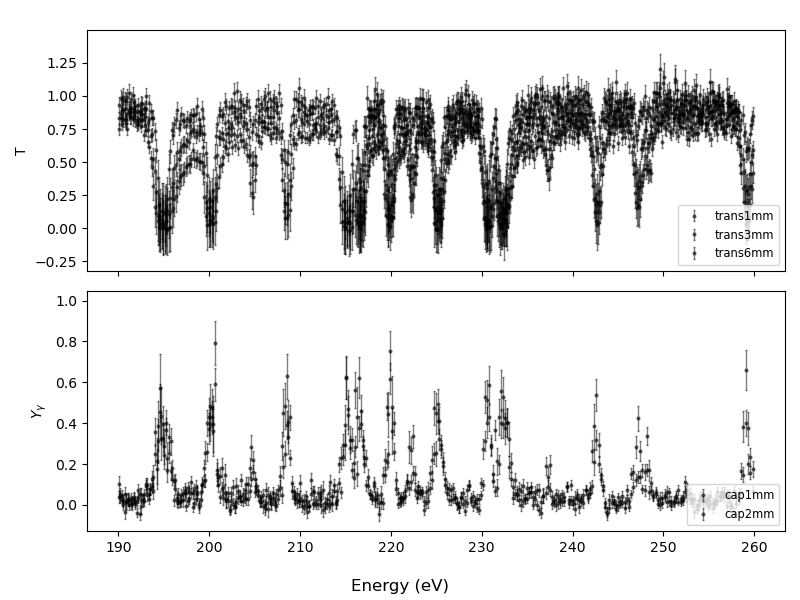

In [178]:
### setup in zipped lists 
datasets = [capdat1, capdat2, transdat1, transdat3, transdat6]
experiments= [expcap1, expcap2, exptrans1, exptrans3, exptrans6]
covariance_data = [{}, {}, transdat1_covfile, transdat3_covfile, transdat6_covfile]
templates = []
for data, exp in zip(datasets, experiments):
    filepath = f'template_{exp.title}_edited'
    exp.template = os.path.realpath(filepath)



fig = plot_datafits(datasets, experiments, 
    # true_pars = true_ladder, 
    prior_pars = pd.DataFrame(),
)

fig.tight_layout()


## Fit from ENDF or JEFF

In [179]:
sammyRTO = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   False,
                              "keep_runDIR"     : True
                              })

matnum = 7328

# endf_file = "/Users/noahwalton/research_local/data/neutrons_ENDF-B-VII.1/n-073_Ta_181.endf"
# endf_parameters = sammy_functions.get_endf_parameters(endf_file, matnum, sammyRTO)

# endf_parameters = endf_parameters[(endf_parameters.E<260) & (endf_parameters.E>190)]
# endf_parameters["varyGn1"] = np.ones(len(endf_parameters))
# endf_parameters["varyGg"] = np.ones(len(endf_parameters))*0
# endf_parameters["varyE"] = np.ones(len(endf_parameters))

jeff_file = "./73-Ta-181g.jeff33"
jeff_parameters = sammy_functions.get_endf_parameters(jeff_file, matnum, sammyRTO)

jeff_parameters = jeff_parameters[(jeff_parameters.E<np.max(energy_range_all)) & (jeff_parameters.E>np.min(energy_range_all))]
jeff_parameters["varyGn1"] = np.ones(len(jeff_parameters))
jeff_parameters["varyGg"] = np.ones(len(jeff_parameters))*1
jeff_parameters["varyE"] = np.ones(len(jeff_parameters))
jeff_parameters

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
46,194.80,55.0000,99.5555,1.0,1.0,1.0,2.0
47,200.00,63.0000,31.4285,1.0,1.0,1.0,1.0
48,204.67,64.9999,2.7540,1.0,1.0,1.0,1.0
49,208.48,64.9999,9.4220,1.0,1.0,1.0,2.0
50,215.09,64.9999,48.2700,1.0,1.0,1.0,2.0
51,216.60,64.9999,19.3900,1.0,1.0,1.0,1.0
52,219.81,64.9999,12.8800,1.0,1.0,1.0,2.0
53,222.29,64.9999,2.4360,1.0,1.0,1.0,2.0
54,225.15,64.9999,20.5700,1.0,1.0,1.0,2.0
55,230.62,64.9999,22.4200,1.0,1.0,1.0,2.0


In [22]:
# jeff_parameters.drop(index = 53, inplace=True)
# jeff_parameters.drop(index = 54, inplace=True)
# jeff_parameters

In [23]:

Ta_pair = Particle_Pair(isotope="Ta181",
                        formalism="XCT",
                        ac=8.1271,     # scattering radius
                        M=180.948030,  # amu of target nucleus
                        m=1,           # amu of incident neutron
                        I=3.5,         # intrinsic spin, positive parity
                        i=0.5,         # intrinsic spin, positive parity
                        l_max=2)       # highest order l-wave to consider

Ta_pair.add_spin_group(Jpi='3.0',
                       J_ID=1,
                       D_avg=8.79,
                       Gn_avg=46.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)

Ta_pair.add_spin_group(Jpi='4.0',
                       J_ID=2,
                       D_avg=4.99,
                       Gn_avg=35.5,
                       Gn_dof=1,
                       Gg_avg=64.0,
                       Gg_dof=1000)


rto = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                             {"Print"   :   True,
                              "bayes"   :   True,
                              "keep_runDIR"     : True,
                              "sammy_runDIR": "sammy_runDIR_1"
                              })


sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = jeff_parameters,  

    datasets= datasets,
    experiments = experiments,
    experimental_covariance= covariance_data, 
    
    max_steps = 10,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 2,
    LevMarVd= 5,
    initial_parameter_uncertainty = 0.01
    )



In [24]:
from ATARI.AutoFit.functions import *
external_resonance_ladder = generate_external_resonance_ladder([each[1] for each in Ta_pair.spin_groups.items()], energy_range_all)
jeff_parameters_wext, external_resonance_indices = concat_external_resonance_ladder(jeff_parameters, external_resonance_ladder)
sammyINPyw.resonance_ladder = jeff_parameters_wext
jeff_parameters_wext

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,218.79,64.0000,46.500,0.0,1.0,1.0,1.0
1,192.21,64.0000,46.500,0.0,1.0,1.0,1.0
2,214.99,64.0000,35.500,0.0,1.0,1.0,2.0
3,196.01,64.0000,35.500,0.0,1.0,1.0,2.0
4,204.67,64.9999,2.754,1.0,1.0,1.0,1.0
5,208.48,64.9999,9.422,1.0,1.0,1.0,2.0


In [25]:
sammyOUT = sammy_functions.run_sammy_YW(sammyINPyw, rto)

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum', 'sum/ndat']
0    0.01 : [46.8048, 102.953, 52.0032, 120.771, 342.333, 664.865, 2.577]
1    0.02 : [38.5471, 106.524, 53.8564, 112.264, 294.88, 606.0715, 2.3491]
2    0.04 : [38.6547, 105.779, 50.4934, 107.63, 287.745, 590.3021, 2.288]
3    0.08 : [40.29, 105.443, 42.6126, 96.9117, 269.264, 554.5213, 2.1493]
4    0.16 : [47.3169, 110.075, 32.0608, 78.6835, 228.629, 496.7652, 1.9254]
5    0.32 : [45.5747, 101.359, 25.1109, 49.2108, 123.767, 345.0224, 1.3373]
6    0.64 : [35.6326, 90.4104, 23.3067, 36.0502, 78.7424, 264.1423, 1.0238]
7    1.28 : [36.8805, 94.1571, 20.5574, 32.1982, 74.3396, 258.1328, 1.0005]
8    2.56 : [38.4376, 95.0371, 19.7104, 31.0942, 72.6299, 256.9092, 0.9958]
Chi2 improvement below threshold


In [26]:
# prior_lsts = lsts
print(sammyOUT.chi2n, np.sum(sammyOUT.chi2n))
print(sammyOUT.chi2n_post, np.sum(sammyOUT.chi2n_post))

print(sammyOUT.chi2, np.sum(sammyOUT.chi2))
print(sammyOUT.chi2_post, np.sum(sammyOUT.chi2_post))

[0.9751, 2.14485, 0.963022, 2.23651, 6.33951] 12.658992
[0.800783, 1.97994, 0.365008, 0.575819, 1.345] 5.06655
[46.8048, 102.953, 52.0032, 120.771, 342.333] 664.865
[38.4376, 95.0371, 19.7104, 31.0942, 72.6299] 256.9092


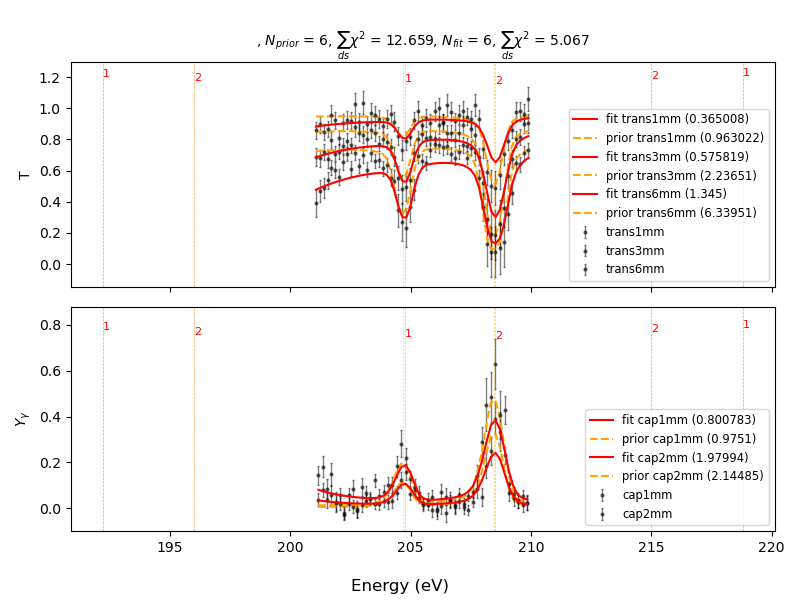

In [27]:
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT.pw_post,
    fit_pars=sammyOUT.par_post,
    fits_chi2=sammyOUT.chi2n_post,
    priors=sammyOUT.pw,
    prior_pars = sammyOUT.par,
    priors_chi2= sammyOUT.chi2n
)

fig.tight_layout()

## AutoFit

In [28]:
from ATARI.AutoFit import initial_FB_solve
importlib.reload(initial_FB_solve)

sammy_rto_fit = sammy_classes.SammyRunTimeOptions('/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
                                        {"Print":   True,
                                         "bayes":   True,
                                         "keep_runDIR": True,
                                         "sammy_runDIR": "sammy_runDIR"
                                         })


options = initial_FB_solve.InitialFBOPT(Gn_threshold=1e-2,
                       iterations=3,
                       max_steps = 30,
                       step_threshold=0.001,
                       LevMarV0=0.05,

                       fit_all_spin_groups=False,
                       spin_group_keys = ['3.0'],
                       
                       starting_Gn1_multiplier=10,
                       external_resonances=True)

autofit_initial = initial_FB_solve.InitialFB(options)

In [29]:
initial_out = autofit_initial.fit(Ta_pair,
                            #    [200,230],
                           energy_range_all,
                               datasets,
                               experiments,
                               covariance_data,
                               sammy_rto_fit)


	FIT 1
Initial solve from 11 resonance features

Stepping until convergence
chi2 values
step fudge: ['cap1mm', 'cap2mm', 'trans1mm', 'trans3mm', 'trans6mm', 'sum', 'sum/ndat']
0    0.05 : [221.091, 340.261, 22.5898, 24.8969, 26.753, 635.5917, 2.4635]
1    0.075: [220.964, 340.016, 22.5767, 24.8565, 26.6881, 635.1013, 2.4616]
2    0.113: [220.674, 339.454, 22.5466, 24.7634, 26.5385, 633.9765, 2.4573]
3    0.169: [219.987, 338.131, 22.4756, 24.5436, 26.1838, 631.321, 2.447]
4    0.253: [218.254, 334.823, 22.2962, 23.9874, 25.2825, 624.6431, 2.4211]
5    0.38 : [213.069, 325.195, 21.7552, 22.3357, 22.6914, 605.0463, 2.3451]
6    0.57 : [191.32, 287.073, 19.5988, 17.2947, 18.9379, 534.2244, 2.0706]
7    0.854: [128.473, 191.254, 15.5112, 19.0992, 46.2062, 400.5436, 1.5525]
8    1.281: [110.471, 173.005, 15.869, 22.5172, 51.7759, 373.6381, 1.4482]
9    1.922: [108.538, 178.85, 16.7081, 20.7771, 42.3281, 367.2013, 1.4233]
10    2.883: [108.724, 180.123, 16.8337, 20.1791, 39.879, 365.7388, 1.

In [30]:
start_ladder =  copy(initial_out.final_internal_resonances)
external_resonances = copy(initial_out.final_external_resonances)
assert(isinstance(start_ladder, pd.DataFrame))
assert(isinstance(external_resonances, pd.DataFrame))
start_ladder['varyGg'] = np.zeros(len(start_ladder))
start_ladder = pd.concat([external_resonances, start_ladder], ignore_index=True)
external_resonance_indices = [0,1]

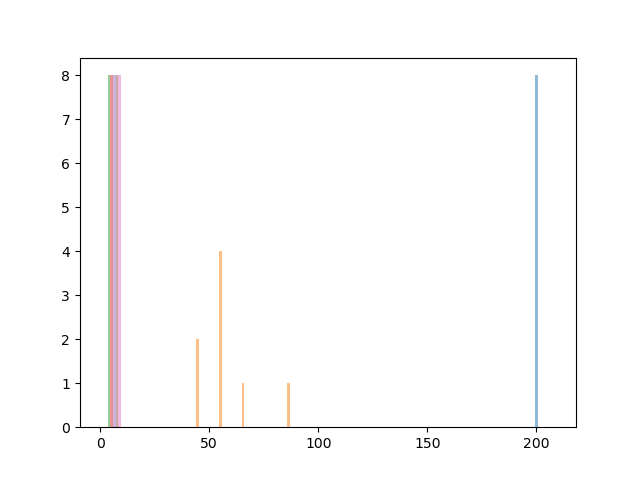

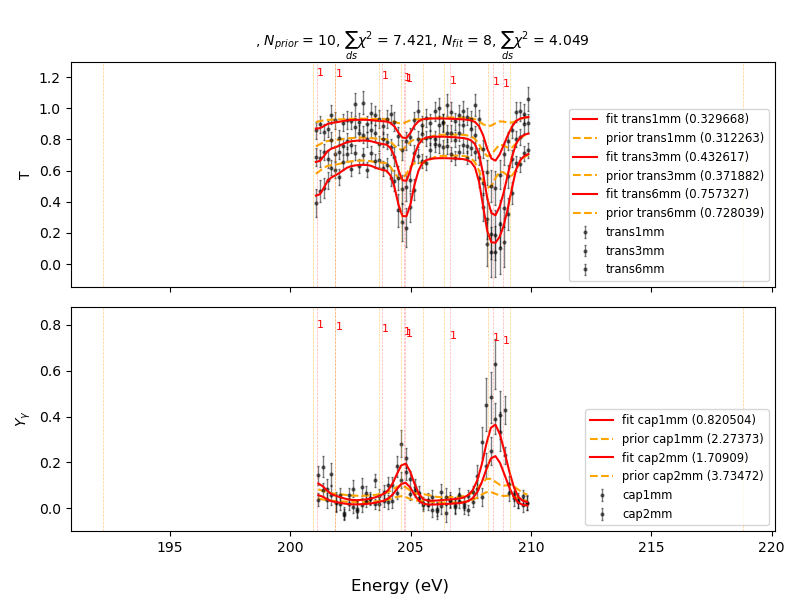

In [31]:
import matplotlib.pyplot as plt
sammyOUT_initialFB = initial_out.sammy_outs_fit_2[-1]
figure()
# _ = plt.hist(np.log10(sammyOUT_initialFB.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(initial_out.final_internal_resonances, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_initialFB.pw_post,
    fit_pars=initial_out.final_internal_resonances,
    fits_chi2=sammyOUT_initialFB.chi2n_post,
    priors=sammyOUT_initialFB.pw,
    prior_pars = sammyOUT_initialFB.par,
    priors_chi2= sammyOUT_initialFB.chi2n
)

fig.tight_layout()

In [36]:
import importlib
from ATARI.AutoFit import chi2_eliminator_v2

elim_sammyINPyw = sammy_classes.SammyInputDataYW(
    particle_pair = Ta_pair,
    resonance_ladder = start_ladder,

    datasets = datasets,
    experimental_covariance=covariance_data,
    experiments = experiments,

    max_steps = 5,
    iterations = 3,
    step_threshold = 0.01,
    autoelim_threshold = None,

    LS = False,
    LevMar = True,
    LevMarV = 1.5,

    minF = 1e-5,
    maxF = 10,
    initial_parameter_uncertainty = 0.05
    )

# defining the elim_opts
elim_opts = chi2_eliminator_v2.elim_OPTs(chi2_allowed = 0,
                                         stop_at_chi2_thr = False,
                                      fixed_resonances_df = external_resonances,
                                      deep_fit_max_iter = 5,
                                      deep_fit_step_thr = 0.1,
                                      start_fudge_for_deep_stage = 0.05,
                                      )

elimi = chi2_eliminator_v2.eliminator_by_chi2(rto=sammy_rto_fit,
                                            sammyINPyw = elim_sammyINPyw , 
                                            options = elim_opts
                            )

history = elimi.eliminate(ladder_df=start_ladder)

****************************************
Elimination cycle printout enabled
****************************************

Chi2 thresold applied for model selection: 0


Input ladder:
            E          Gg         Gn1  varyE  varyGg  varyGn1  J_ID
0  218.790000   79.083737  162.548620    0.0     1.0      1.0   1.0
1  192.210000  334.165394  316.083914    0.0     1.0      1.0   1.0
2  201.115085   93.132615    0.968613    1.0     0.0      1.0   1.0
3  201.874932   54.459268    0.195810    1.0     0.0      1.0   1.0
4  203.793017   61.295374    0.155392    1.0     0.0      1.0   1.0
5  204.739829   48.983269    2.331382    1.0     0.0      1.0   1.0
6  204.783077   59.091890    0.255234    1.0     0.0      1.0   1.0
7  206.621239   63.807752    0.012766    1.0     0.0      1.0   1.0
8  208.407809   51.037145    5.511033    1.0     0.0      1.0   1.0
9  208.839033   60.789767    2.275621    1.0     0.0      1.0   1.0
Side resonances used:
        E          Gg         Gn1  varyE  varyGg  v

In [39]:
minkey = min(history.elimination_history.keys())
maxkey = max(history.elimination_history.keys())
print(minkey)
print(maxkey)
models = [history.elimination_history[i]['selected_ladder_chars'] for i in range(minkey, maxkey+1)]
# models

3
10


Eliminated from 10 res -> 9


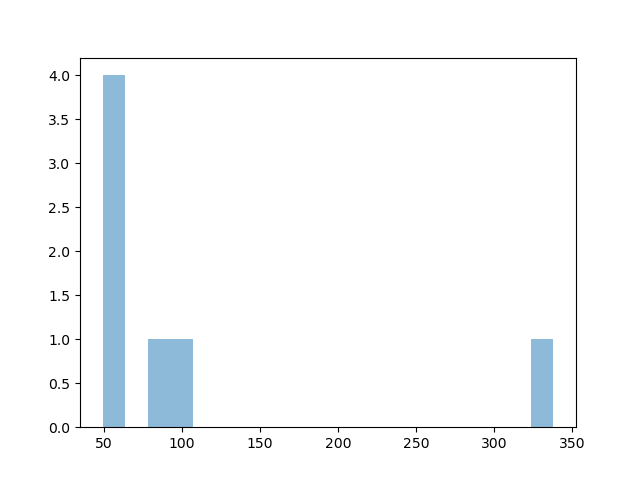

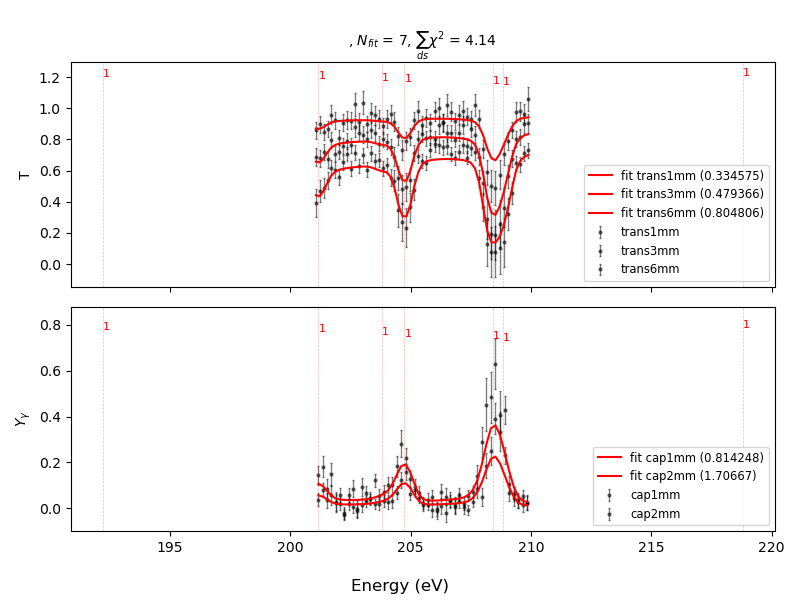

In [43]:
print(f'Eliminated from {history.ladder_IN.shape[0]} res -> {history.ladder_OUT.shape[0]}')
minkey = min(history.elimination_history.keys())

sammyOUT_elim = history.elimination_history[minkey+5]['selected_ladder_chars']

figure()
# _ = plt.hist(np.log10(sammyOUT_elim.par_post.Gn1), bins=20, label="Gn1")
_= plt.hist(sammyOUT_elim.par_post.Gg, bins=20, label="Gg", alpha=0.5)

fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_elim.pw_post, 
    fits_chi2=sammyOUT_elim.chi2n_post,
    priors=[], priors_chi2=[],
    # true=datasets, 
    true_chi2=[],
    # true_pars = true_ladder, 
    # prior_pars = pd.DataFrame(),
    fit_pars = sammyOUT_elim.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

In [46]:
internal, external = separate_external_resonance_ladder(sammyOUT_elim.par_post, [0,1])
internal

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
2,201.169130,93.132615,0.955245,1.0,0.0,1.0,1.0
3,203.805900,61.295374,0.155817,1.0,0.0,1.0,1.0
4,204.744399,48.983269,2.537562,1.0,0.0,1.0,1.0
5,208.406275,51.037145,5.420118,1.0,0.0,1.0,1.0
6,208.839126,60.789767,2.269770,1.0,0.0,1.0,1.0


In [183]:
import pickle
from ATARI.AutoFit import spin_group_selection
importlib.reload(spin_group_selection)

spinselectOPT = spin_group_selection.SpinSelectOPT(step_threshold=0.01,
                                                    max_steps=10,
                                                    LevMarV0 = 0.1)
spinselector = spin_group_selection.SpinSelect(spinselectOPT)


all_possible_reslad = spin_group_selection.get_all_resonance_ladder_combinations([1.0, 2.0], jeff_parameters) #internal)




# models = [history.elimination_history[i]['selected_ladder_chars'] for i in range(minkey+1, minkey+3)]

# spinselect_out = spinselector.fit_multiple_models(models,
#                                 [1.0,2.0],
#                                 Ta_pair,
#                                 datasets,
#                                 experiments,
#                                 covariance_data,
#                                 sammy_rto_fit,
#                                 external_resonance_indices)
# ladder = all_possible_reslad[0]
# print(ladder)

# spinselector.try_all_spin_groups( 
#                       [1.0,2.0],
#                       ladder,
#                       Ta_pair,
#                       datasets,
#                       experiments,
#                       covariance_data,
#                       sammy_rto_fit,
#                       external_resonance_indices=[])

In [198]:
# for each in all_possible_reslad:
print(len(jeff_parameters))
print(len(all_possible_reslad))

17
131072


In [235]:
print(2**5)
print(2**12)

32
4096


In [185]:

LLs = []
for ladder in all_possible_reslad:
    LL_par = get_LL_by_parameter(ladder, Ta_pair.spin_groups)
    LL = np.sum(LL_par)
    LLs.append(LL)
nLLs = np.array(LLs)
index = np.argsort(LLs)


In [234]:
np.sum(get_LL_by_parameter(jeff_parameters, Ta_pair.spin_groups))

-156.41079172959854

In [229]:
LLs = nLLs
sort_index = index
max_num = min( 2000, len(sort_index))
indices_to_evaluate = sort_index[-max_num:]

Text(0.5, 1.0, 'Likelihood (over all 3 parameters) for all possible spin combinations\n Ladder: JEFF 3.3 190-260 eV')

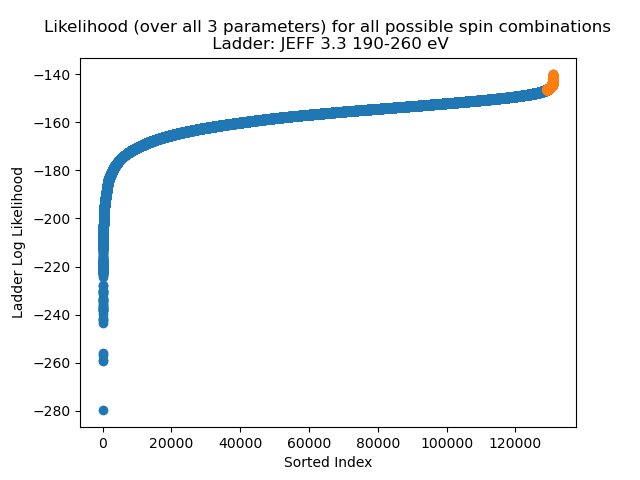

In [232]:
figure()
scatter(range(len(all_possible_reslad)), LLs[index])
scatter(range(len(all_possible_reslad))[-max_num:], LLs[indices_to_evaluate])
ylabel("Ladder Log Likelihood")
xlabel("Sorted Index")
title("Likelihood (over all 3 parameters) for all possible spin combinations\n Ladder: JEFF 3.3 190-260 eV")


In [ ]:
from ATARI.AutoFit.control import AutoFitOUT

autofit_out = AutoFitOUT(initial_out, history, spinselect_out)

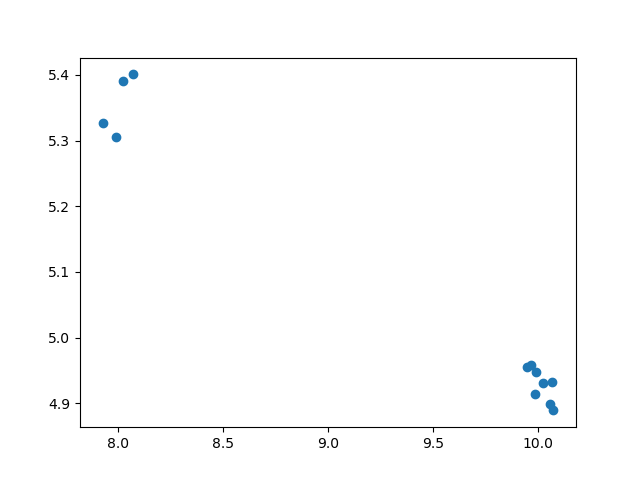

In [25]:
# all_chi2n = [np.sum(each.chi2n_post) for each in spinselectOUT.all_sammy_outs]
x = []
y = []
for key, val in spinselect_out.history.items():
    x.extend([float(key)]*len(val['all_chi2n']) )
    y.extend(val['all_chi2n'])


x = np.array(x) + x + np.random.default_rng().uniform(-0.1,0.1, size=len(x))
figure()
scatter(x, y)


# _ = hist(all_chi2n, bins=100, density=False)
# scatter(range(len(all_chi2n)), all_chi2n)
# axhline(np.sum(spinselectOUT.leading_model.chi2n_post), color='r')

In [26]:
print(sammyOUT_elim.chi2n_post, np.sum(sammyOUT_elim.chi2n_post))
print(sammyOUT_spin.chi2n_post, np.sum(sammyOUT_spin.chi2n_post))
print(sammyOUT_elim.par_post)
print(sammyOUT_spin.par_post)
fig = plot_datafits(datasets, experiments, 
    fits=sammyOUT_spin.pw_post, 
    fits_chi2=sammyOUT_spin.chi2n_post,
    priors=[], priors_chi2=[],
    # true=sammyOUT.pw_post, 
    # true_chi2= sammyOUT.chi2n_post,
    # true_pars = sammyOUT.par_post, 
    prior_pars = sammyOUT_elim.par_post,
    fit_pars = sammyOUT_spin.par_post,
    # title: str = '',
    show_spingroups = True,
    fig_size = (8,6)
)

fig.tight_layout()

[0.779351, 1.80442, 0.599216, 0.869041, 1.71593] 5.767958


NameError: name 'sammyOUT_spin' is not defined

### Next steps

Before giving this to oleksii for AIC, I could fit background with external resonances
1. fix the result above
2. add external resonances on either side of the window with fixed energies
3. Fit external resonance widths to capture background
4. give results to Oleksii where AIC will eliminate and re-fit all internal resonance parameters and only widths of external resonances


In [ ]:
import pickle

# open a file, where you ant to store the data
file = open('./initialFB.pkl', 'wb')
pickle.dump(start_ladder, file)
file.close()

for i in range(9,13):
    obj = history.elimination_history[i]['selected_ladder_chars']
    file = open(f'./elim_{i}.pkl', 'wb')
    pickle.dump(obj, file)
    file.close()
    
# for i in range(9,12):
#     obj = history.elimination_history[i]['selected_ladder_chars']
# # file = open('./spin_group.pkl', 'wb')
# # pickle.dump(start_ladder, file)
# # file.close()

In [ ]:
file = open('./spin_model_12.pkl', 'rb')
fbout = pickle.load(file)
file.close()

In [ ]:
fbout.par_post

,E,Gg,Gn1,varyE,varyGg,varyGn1,J_ID
0,204.741872,54.075581,2.348920,1.0,0.0,1.0,2.0
1,208.522334,57.442773,8.921431,1.0,0.0,1.0,2.0
2,214.831151,3.060050,10.774297,1.0,0.0,1.0,1.0
3,215.294030,78.994529,21.835185,1.0,0.0,1.0,1.0
4,216.627523,103.291985,17.032382,1.0,0.0,1.0,1.0
5,219.761676,32.482910,7.020997,1.0,0.0,1.0,1.0
6,219.971992,70.570667,6.961697,1.0,0.0,1.0,1.0
7,222.304332,61.647417,2.630040,1.0,0.0,1.0,2.0
8,225.208830,78.575612,23.435459,1.0,0.0,1.0,1.0
9,200.000000,64.998137,67.145788,0.0,1.0,1.0,1.0
